# Predicting Movie Attendance
The goal of the present Jupyter notebook is to develop and compare some classifiers/regressors for data analysis of a dataset composed of sold movie tickets. The task is to predict at daily level with at least one week in advance.

## 3) Data Exploration
In this section data exploration after feature engineering to understand which variables might impact in the model.

### 3.1) Statistical inference and plots
Having captured for each day the variables (time and movie played) then a brief statistical analysis of the dataset is presented.

#### Library loading

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline
sns.set_style('darkgrid')
sns.set_context("notebook")
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [10]:
train = pd.read_csv('./data/sales_train.csv')
train.head()

,Day,BOLETOS,month,day_name,day_type,day_tipo,April,August,December,February,...,HML,MHL,NHM,HHM,NHL,LHL,NLL,HMM,NLM,HMH
0,2016-01-01,2.082259,January,Friday,weekday,RDAY,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
1,2016-01-02,2.051443,January,Saturday,weekend,HDAY,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2,2016-01-03,2.097130,January,Sunday,weekend,HDAY,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,2016-01-04,0.678215,January,Monday,weekday,HDAY,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
4,2016-01-05,0.736246,January,Tuesday,weekday,HDAY,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


#### Ticket sales histogram
The ticket sales is clearly skewed. This reflect that there is a heavy purchase on certain days compared to others.

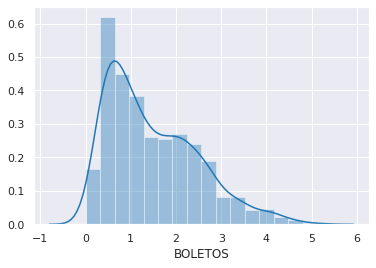

In [11]:
sns.distplot(train.BOLETOS)
plt.show()

From the correlogram it can be seen that some variables impact directly to the ticket sales: weekend/weekdays.

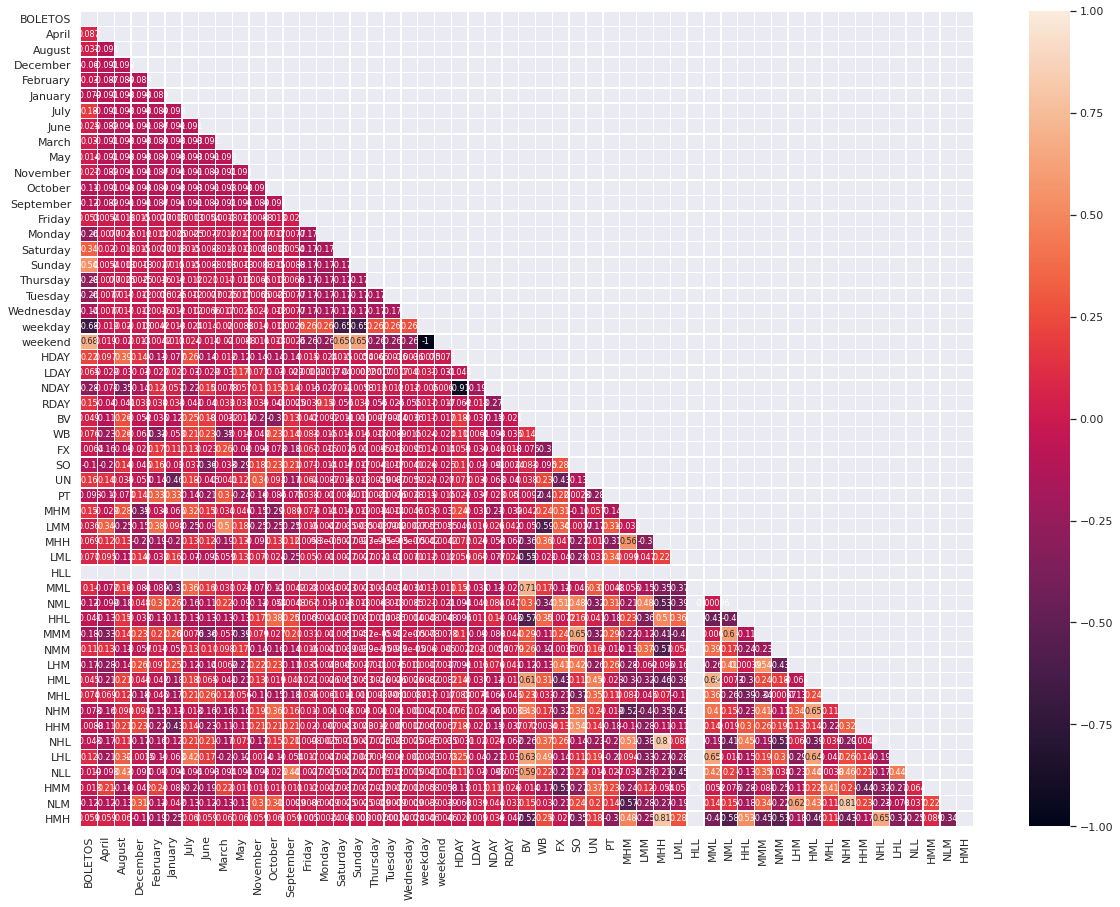

In [12]:
corr = train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(20,15))
sns.heatmap(corr, annot=True, linewidth=0.5, mask=mask, annot_kws={"size": 8})
plt.show()

The sales-by-day reflect that starting on Friday to Sunday the sales go up. This reflects that leisure days used to assit movie theaters.

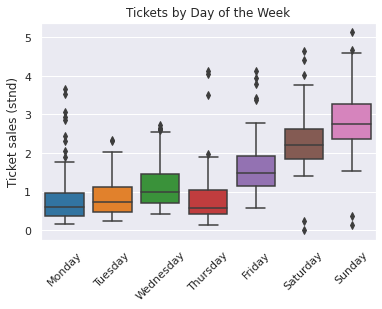

In [13]:
order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='day_name', y='BOLETOS', data=train, order=order)
plt.title('Tickets by Day of the Week', fontsize=12)
plt.xlabel('')
plt.ylabel('Ticket sales (stnd)')
plt.xticks(rotation=45)
plt.show()

In [14]:
train.month.unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype=object)

The month sales reflect that there is a heavy attendace on summer vacations. This matches with the empirical data about movies' summer releases.

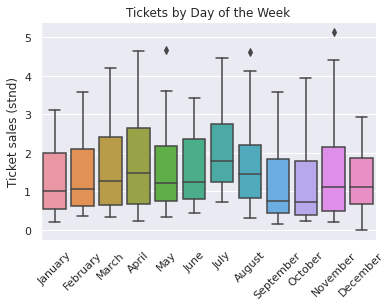

In [15]:
order=['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December']
sns.boxplot(x='month', y='BOLETOS', data=train, order=order)
plt.title('Tickets by Day of the Week', fontsize=12)
plt.xlabel('')
plt.ylabel('Ticket sales (stnd)')
plt.xticks(rotation=45)
plt.show()

### 4) Model construction
It was stated that this type of problem can be estimated with Random Forests. But in order to probe that this technique for forcasting can be used, it will be compared to other models. The following analysis is conducted using linear models and Gradient Boost.

#### Library loading

In [16]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn import linear_model
import time

In [17]:
X = train.drop(['Day', 'BOLETOS', 'month', 'day_name', 'day_type', 'day_tipo'], axis=1)
y = train.BOLETOS
print(X.columns.values)
print(type(X.columns.values))
print(len(X.columns.values))
Xcols = np.append(X.columns.values, ['constant'])

['April' 'August' 'December' 'February' 'January' 'July' 'June' 'March'
 'May' 'November' 'October' 'September' 'Friday' 'Monday' 'Saturday'
 'Sunday' 'Thursday' 'Tuesday' 'Wednesday' 'weekday' 'weekend' 'HDAY'
 'LDAY' 'NDAY' 'RDAY' 'BV' 'WB' 'FX' 'SO' 'UN' 'PT' 'MHM' 'LMM' 'MHH'
 'LML' 'HLL' 'MML' 'NML' 'HHL' 'MMM' 'NMM' 'LHM' 'HML' 'MHL' 'NHM' 'HHM'
 'NHL' 'LHL' 'NLL' 'HMM' 'NLM' 'HMH']
<class 'numpy.ndarray'>
52


To capture better the influence of the variables, these were also scaled to be standard.

In [18]:
ss = StandardScaler()
Xscaled = ss.fit_transform(X)
Xscaled = add_constant(Xscaled)

The datasets were splited in a three to one ratio for testing and training (75% for model training and 25% for model validation)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(Xscaled, y, test_size = 0.25, random_state =42)


### 4.1) Base model
The linear model (y = X_0 + aX_1 + ... + aX_n) is the base of our comparison. To determine the accuracy of the model the R^2 score is used as a base line.

In [20]:
lin_model = OLS(y_train, X_train).fit()
lin_pred = lin_model.predict(X_test)
lin_model_score = r2_score(y_test, lin_pred)

print('R^2 score:', lin_model_score)
print(lin_model.summary())

R^2 score: 0.712976487377943
                            OLS Regression Results                            
Dep. Variable:                BOLETOS   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     34.12
Date:                Sat, 28 Mar 2020   Prob (F-statistic):          1.95e-124
Time:                        19:19:36   Log-Likelihood:                -385.58
No. Observations:                 548   AIC:                             863.2
Df Residuals:                     502   BIC:                             1061.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4735  

Seeking to compare the models, various functions are designed to reflect the R^2 test and the graph between residuals and predictors. Finally, the grid search is an opportunity to optimize the Random Forest model and also the Gradient Boost model.
- The evaluation model test each one of these with de R^2 score and graph the predictions vs. the residuals.
- The feature importance function, help to visualize which variables influence more on the model.
- The grid search function will be used to optimize the two cited models.

In [21]:
def evaluate(model):        
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    model_score = r2_score(y_test, pred)
    
    param = cross_val_score(model, X, y, cv=5, scoring='r2', n_jobs=-1)
    
    print('==============================================================================')
    print('R^2 score:', model_score)
    print('Cross Validation Score: {:0.3} ± {:0.3}'.format(param.mean().round(3), param.std().round(3)))
    print('==============================================================================')
    
    df = pd.DataFrame(columns=['tickets', 'predictions', 'residuals'])
    df.attendance = y
    df.predictions = model.predict(Xscaled)
    df.residuals = df.attendance - df.predictions
    df.plot(x='predictions', y='residuals', kind='scatter')
    plt.show()
    print('==============================================================================')
    
def feature_imp(model):
    feat_imp = pd.DataFrame({'importance': model.feature_importances_}, index=Xcols).sort_values('importance', ascending=False).reset_index()
    print('==============================================================================')
    print('Most important features in the model:')
    print(feat_imp[0:9])
    print('==============================================================================')
    feat_imp[0:20].plot(x='index', y='importance', kind='bar')
    plt.xlabel('   ')
    plt.ylabel('Importance')
    plt.legend().set_visible(False)
    plt.show()
    return feat_imp

def grid_search(model):
    params = {
        'max_features' : [0.1, 0.25, 0.5, 0.75, 'auto', 'sqrt'],
        'max_depth' : [10, 20, 30, None],
    }

    gs_rf = GridSearchCV(model, params, n_jobs=-1, cv=5)
    gs_rf.fit(X_train, y_train)

    print(gs_rf.best_params_)

### 4.2) Other lineal models
Other lineal models which have a different optimization function to minimum least squares were tested to compare the basic Linear Regression Model.

#### Ridge Model
Similar to the Linear Regression Model offers no better estimation.

R^2 score: 0.7131642095129294
Cross Validation Score: 0.089 ± 0.345


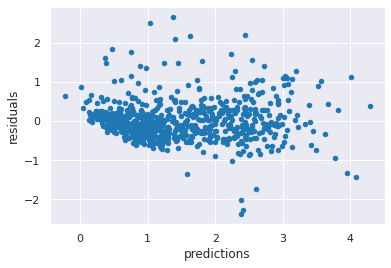

CPU times: user 307 ms, sys: 224 ms, total: 531 ms
Wall time: 699 ms


In [22]:
lin_mod = linear_model.Ridge (alpha = .5)
%time evaluate(lin_mod)

#### Crossvalidating the Ridge Linear Model
NOTE: Cross validation is a randomized procedure. the randomly assign samples to one of k folds, estimate the error statistic in the usual k-fold cross validation way. Depends on which samples are in which fold, it will get different parameter estimates and hence different predictions.

This Model is similar to the Linear Regression Model, it offers no advantage in forecasting.

R^2 score: 0.7134832669246063
Cross Validation Score: 0.116 ± 0.325


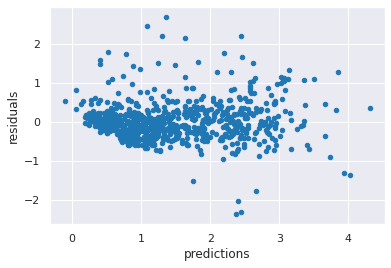

CPU times: user 265 ms, sys: 240 ms, total: 505 ms
Wall time: 204 ms


In [23]:
lin_mod = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0])
%time evaluate(lin_mod)

The Lasso Linear model is sensitive to outliers, therefore the los R^2 score reflects the curtosis seen in the statistical graph of the ticket sales.

R^2 score: 0.6193858166542037
Cross Validation Score: 0.367 ± 0.083


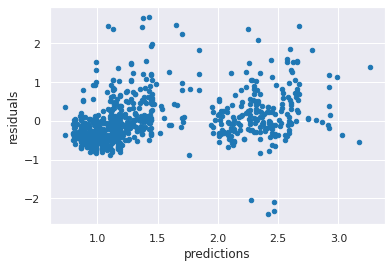

CPU times: user 252 ms, sys: 225 ms, total: 477 ms
Wall time: 199 ms


In [24]:
lin_mod = linear_model.Lasso(alpha = 0.1)
%time evaluate(lin_mod)

The Bayesian Ridge also offers no advantage to the Linear Regression Model. There fore the probabilistic terms on the parameters to regularize them has little effect.

R^2 score: 0.7119699382859748
Cross Validation Score: 0.185 ± 0.268


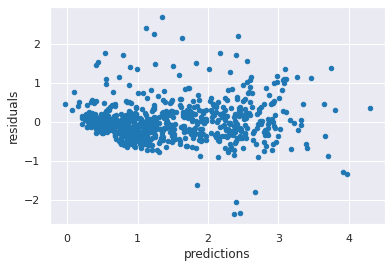

CPU times: user 304 ms, sys: 270 ms, total: 574 ms
Wall time: 219 ms


In [25]:
lin_mod = linear_model.BayesianRidge()
%time evaluate(lin_mod)

### 4.3) Gradient Boost and Random Forest Regressors
Modelling theory states that boosting is based on weak learners (high bias, low variance). In terms of decision trees, weak learners are shallow trees, sometimes even as small as decision stumps (trees with two leaves). Boosting reduces error mainly by reducing bias (and also to some extent variance, by aggregating the output from many models).

Random Forest uses as you said fully grown decision trees (low bias, high variance). It tackles the error reduction task in the opposite way: by reducing variance. The trees are made uncorrelated to maximize the decrease in variance.

These two models seem promising to tackle the ticket sales problem.

### 4.3.1) Random Forest
Random Forest has an increase in the R^2 score suggesting that it can capture better the variable influence on the ticket sales. Also it can be seen that the important features in the model fall on the weekend days but also holidays.

R^2 score: 0.7419912749586705
Cross Validation Score: 0.618 ± 0.143


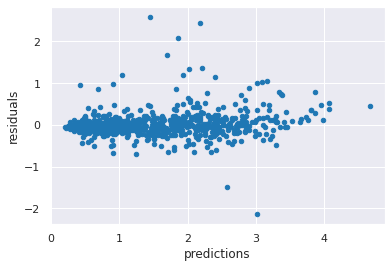

CPU times: user 933 ms, sys: 107 ms, total: 1.04 s
Wall time: 2.34 s
Most important features in the model:
      index  importance
0      HDAY    0.232591
1   weekend    0.228546
2      RDAY    0.080249
3    Monday    0.059628
4        PT    0.035656
5  February    0.024466
6        WB    0.024367
7      June    0.021551
8        FX    0.019925


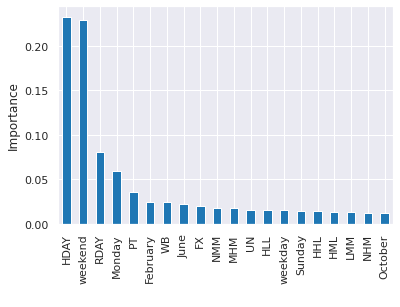

In [26]:
RndFR = RandomForestRegressor(n_estimators=250)
%time evaluate(RndFR)
RFR = feature_imp(RndFR)

### 4.3.2) Gradient Boosting
Gradient Boosting also has an increase in the R^2 score suggesting that it can capture better the variable influence on the ticket sales. Also it can be seen that there is a preference on the sudio movie as the important features in the model. This contradicts the basic statistics in the begining of the notebook.

R^2 score: 0.7285221312631814
Cross Validation Score: 0.553 ± 0.156


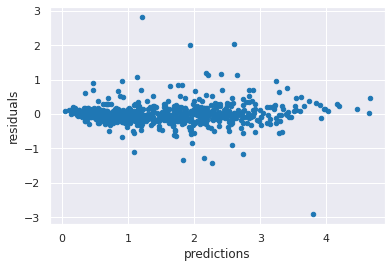

CPU times: user 433 ms, sys: 110 ms, total: 543 ms
Wall time: 849 ms
Most important features in the model:
      index  importance
0      HDAY    0.320529
1   weekend    0.142340
2      RDAY    0.075246
3    Monday    0.059420
4        PT    0.043155
5        WB    0.030697
6  Thursday    0.027076
7  February    0.026192
8       NMM    0.023069


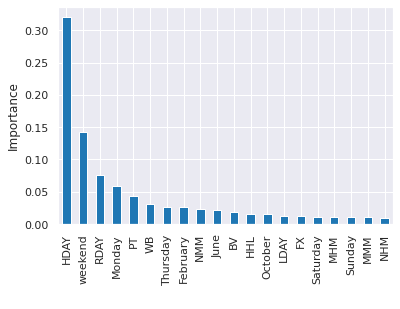

In [27]:
GradBR = GradientBoostingRegressor(n_estimators=300)
%time evaluate(GradBR)
GBR = feature_imp(GradBR)

### 4.4) Model Tuning and Prediction
All machine learning algorithms have a “default” set of hyperparameters, these can be changed to get a better prediction. Tuning allows to customize the models so they generate the most accurate outcomes and give highly valuable insights into data, enabling to make the most effective business decisions.

### 4.4.1) Prediction set
Using the previous data wrangling, the test data set is transformed to test the Linear, Random Forest and Gradient Boost Regression Models.

In [28]:
test = pd.read_csv('./data/sales_test.csv')
X_pred = test.drop(['Day', 'BOLETOS', 'month', 'day_name', 'day_type', 'day_tipo'], axis=1)
X_pred.head(10)

,April,August,December,February,January,July,June,March,May,November,...,HML,MHL,NHM,HHM,NHL,LHL,NLL,HMM,NLM,HMH
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0


In [29]:
Xsc_pred = ss.fit_transform(X_pred)
Xsc_pred = add_constant(Xsc_pred)

### 4.4.2) The Linear Regression Model Prediction

In [30]:
lin_pred = lin_model.predict(Xsc_pred)
print(lin_pred)

[0.99601373 0.77873732 1.04811773 0.66411514 1.57933596 2.377848
 2.87029289]


### 4.4.3) Grid Search for Random Forest Regression
The grid search for Random Forest tries to detrmine the depth and features hyperparameters.

In [31]:
%time grid_search(RndFR)

{'max_depth': 30, 'max_features': 0.25}
CPU times: user 533 ms, sys: 746 µs, total: 534 ms
Wall time: 12.9 s


The hyperparameters suggested by grid search are used to recalculate the Regressor.

R^2 score: 0.7408742807193066
Cross Validation Score: 0.622 ± 0.089


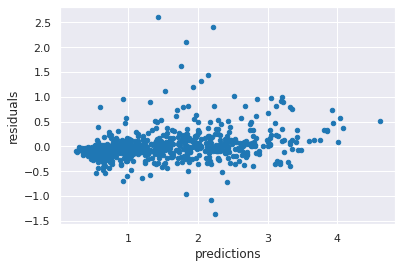

CPU times: user 568 ms, sys: 97.4 ms, total: 665 ms
Wall time: 1.17 s
Most important features in the model:
      index  importance
0   weekend    0.161945
1      HDAY    0.146941
2  Thursday    0.087884
3    Sunday    0.043283
4      RDAY    0.036636
5        PT    0.032395
6    Monday    0.030898
7  Saturday    0.025931
8   Tuesday    0.024042


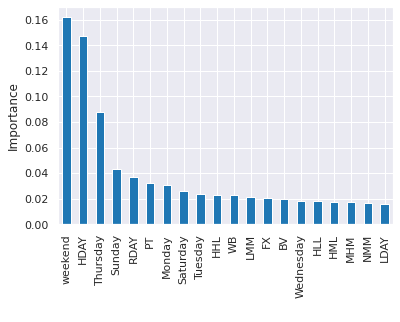

In [32]:
RndFR = RandomForestRegressor(n_estimators=250, max_depth=20, max_features='sqrt')
%time evaluate(RndFR)
Rnd_feat = feature_imp(RndFR)

After tuning the parameters we can see from the plot, that the variable influence is focused on weekends, holidays and Thursdays play an important role on prediction.
NOTE: Premier days are Thursdays in Mexico.

### 4.4.4) The Random Forest Regression Model Prediction

In [33]:
forecast_RndFR = RndFR.predict(Xsc_pred)
print(forecast_RndFR)

[0.62100446 0.68434459 0.9142139  0.6765265  1.55236026 2.33340991
 2.76842968]


### 4.4.5) Grid Search for Gradient Boost Regression
Like the grid search for Random Forest, this is an efforts to detrmine the hyperparameters for Gradient Boost Regression.

In [34]:
%time grid_search(GradBR)

{'max_depth': 10, 'max_features': 'sqrt'}
CPU times: user 274 ms, sys: 1.1 ms, total: 275 ms
Wall time: 10.4 s


It can be noted that the nature to the Gradient Boost and the random trees a loss in the R^2 score can be seen.

R^2 score: 0.7217241751099804
Cross Validation Score: 0.599 ± 0.097


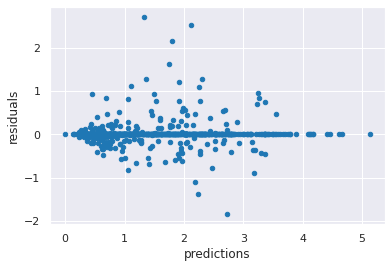

CPU times: user 345 ms, sys: 132 ms, total: 476 ms
Wall time: 629 ms
Most important features in the model:
       index  importance
0    weekend    0.283163
1       HDAY    0.117511
2       RDAY    0.044635
3         PT    0.033558
4   Thursday    0.029985
5     Monday    0.028218
6   Saturday    0.026087
7  Wednesday    0.025324
8         BV    0.024556


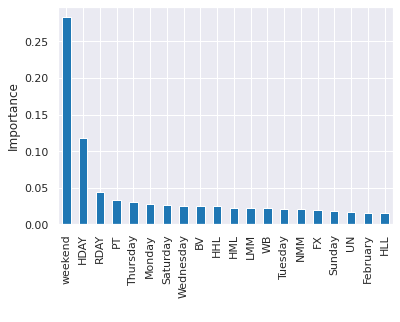

In [35]:
GradBR = GradientBoostingRegressor(n_estimators=250, max_depth=10, max_features='sqrt')
%time evaluate(GradBR)
Grad_feat = feature_imp(GradBR)

After tuning the parameters we can see from the plot, that the variable influence is focused on weekdays, 20th Century Fox films as well as Paramount Pictures films play an important role on prediction.

### 4.4.5) The Gradient Boost Regression Model Prediction

In [36]:
forecast_GradBR = GradBR.predict(Xsc_pred)
print(forecast_GradBR)

[0.6775539  0.76370559 1.08582631 0.76462602 1.7424814  2.32378501
 2.72944824]


### 4.5) One week forecasting with Time Series

Time series analysis can be used in a multitude of business applications for forecasting a quantity into the future and explaining its historical patterns. But, in this case it could capture poorly the time series since tickets selling depend heavily on sesonal timing. Nevertheless, this model is tested.

Like the previous models, data is prepared for the model.

In [37]:
time_s = pd.read_csv('./data/sales_train.csv')
time_s = time_s[['Day', 'BOLETOS']]
time_s.head(10)

,Day,BOLETOS
0,2016-01-01,2.082259
1,2016-01-02,2.051443
2,2016-01-03,2.097130
3,2016-01-04,0.678215
4,2016-01-05,0.736246
5,2016-01-06,0.820632
6,2016-01-07,0.373011
7,2016-01-08,1.003438
8,2016-01-09,1.650276
9,2016-01-10,2.011941


In [38]:
time_s['Day'] = pd.to_datetime(time_s['Day'])
time_s.set_index('Day', inplace=True)
#check datatype of index
time_s.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Day', length=731, freq=None)

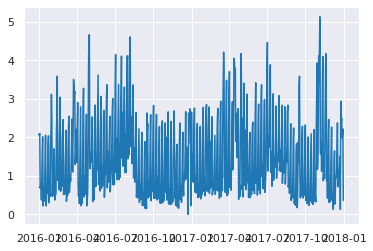

In [39]:
plt.plot(time_s)

Stationary is a very important concept in Time Series Analysis. In order to apply a time series model, it is important for the Time series to be stationary; in other words all its statistical properties (mean,variance) remain constant over time. The Dickey-Fuller test is used to determine this feature.

In [40]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(center=False, window=7).mean()
    rolstd = timeseries.rolling(center=False, window=7).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

This is not stationary because :
- mean is increasing even though the std is small.

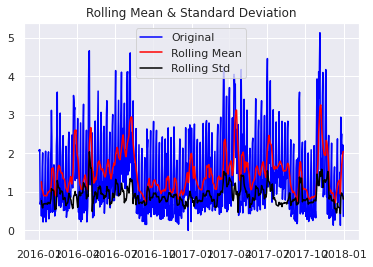

Results of Dickey-Fuller Test:
Test Statistic                  -4.149928
p-value                          0.000800
#Lags Used                      20.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


In [41]:
test_stationarity(time_s['BOLETOS'])

There are two major factors that make a time series non-stationary. They are:
- Trend: non-constant mean
- Seasonality: Variation at specific time-frames

The first step is to reduce the trend using transformation, as it can be seen here that there is a neutral trend.

In [42]:
mov_avg = time_s['BOLETOS'].rolling(center=False, window=7).mean()
ts_mov_avg_diff = time_s['BOLETOS'] - mov_avg
ts_mov_avg_diff = pd.DataFrame(ts_mov_avg_diff)
ts_mov_avg_diff.dropna(inplace=True)
ts_mov_avg_diff.head()

,BOLETOS
Day,
2016-01-07,-0.889694
2016-01-08,-0.105150
2016-01-09,0.598998
2016-01-10,0.972833
2016-01-11,-0.755070


The moving average difference reduces the Test and the p-value is small. This tells that the test statistics is smaller than the 5 % critical values. That tells us that we are 95% confident that this series is stationary.

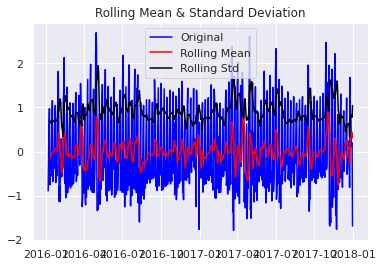

Results of Dickey-Fuller Test:
Test Statistic                -8.840831e+00
p-value                        1.670285e-14
#Lags Used                     1.400000e+01
Number of Observations Used    7.100000e+02
Critical Value (1%)           -3.439594e+00
Critical Value (5%)           -2.865619e+00
Critical Value (10%)          -2.568942e+00
dtype: float64


In [43]:
test_stationarity(ts_mov_avg_diff['BOLETOS'])

Another transformation tested is the exponentially weighted moving average.

In [44]:
expmov_avg = time_s.ewm(span=7).mean()
ts_expmov_avg_diff = time_s - expmov_avg
ts_expmov_avg_diff.head()

,BOLETOS
Day,
2016-01-01,0.000000
2016-01-02,-0.013207
2016-01-03,0.018435
2016-01-04,-0.888305
2016-01-05,-0.558123


Similar to the test above this tells that the test statistics is smaller than the 5 % critical values. That tells us that we are 95% confident that this series is stationary.

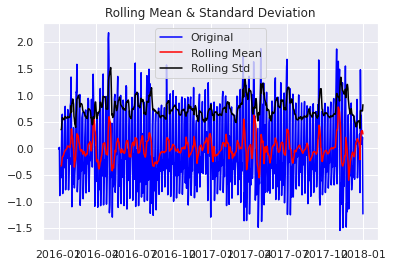

Results of Dickey-Fuller Test:
Test Statistic                -6.333296e+00
p-value                        2.871047e-08
#Lags Used                     2.000000e+01
Number of Observations Used    7.100000e+02
Critical Value (1%)           -3.439594e+00
Critical Value (5%)           -2.865619e+00
Critical Value (10%)          -2.568942e+00
dtype: float64


In [45]:
test_stationarity(ts_expmov_avg_diff['BOLETOS'])

The moving average difference will be used to decompose the Time Series of Ticket Sales.

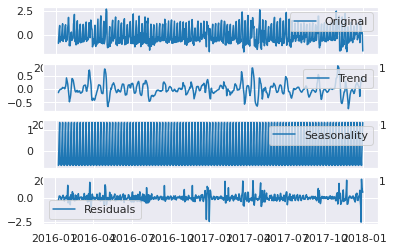

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_mov_avg_diff)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_mov_avg_diff['BOLETOS'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

Now that it has been made the Time Series stationary, the model on the time series using differencing will be used because it is easy to add the error, trend and seasonality back into predicted values. It will be used the statistical modelling method called ARIMA to forecast the data where there are dependencies in the values.

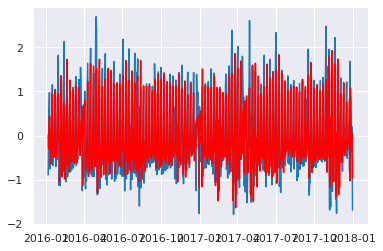

In [47]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_mov_avg_diff, order=(7, 0, 1))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_mov_avg_diff)
plt.plot(results_AR.fittedvalues, color='red')

In [48]:
X_forecast = test[['Day', 'BOLETOS']]
X_forecast['Day'] = pd.to_datetime(X_forecast['Day'])

start_day = X_forecast['Day'][0]
end_day = X_forecast['Day'][6]
X_forecast.set_index('Day', inplace=True)

To forecast a week (7 days), the parameters are given to the ARIMA model and then used to the forecast period.

In [49]:
model = ARIMA(time_s, order=(7, 0, 1))  
results_AR = model.fit(disp=0)  
forecast_ARIMA = results_AR.predict(start=start_day, end=end_day)
print(forecast_ARIMA)

2018-01-01    2.324806
2018-01-02    1.948318
2018-01-03    2.270043
2018-01-04    1.871790
2018-01-05    1.941841
2018-01-06    2.007034
2018-01-07    0.652987
Freq: D, dtype: float64


## 5) Results
After using a basic Linear Regression Model, two tuning Regressors (Random Forests and Gradiet Boostng) and one Time Series analysis (ARIMA), it can be seen that Random forests constructs decision trees that each attempt to decide the ticket sales of a movie. The classifications of each of these trees are then averaged to give a final
and more accurate prediction when compared with the others.

In [50]:
forecast_results = pd.DataFrame(forecast_ARIMA)
forecast_results.rename(columns={0: 'ARIMA'}, inplace=True)
forecast_results['RndFR'] = forecast_RndFR
forecast_results['LR'] = lin_pred
forecast_results.head(7)

,ARIMA,RndFR,LR
2018-01-01,2.324806,0.621004,0.996014
2018-01-02,1.948318,0.684345,0.778737
2018-01-03,2.270043,0.914214,1.048118
2018-01-04,1.871790,0.676526,0.664115
2018-01-05,1.941841,1.552360,1.579336
2018-01-06,2.007034,2.333410,2.377848
2018-01-07,0.652987,2.768430,2.870293


In [51]:
forecast_results['Min'] = forecast_results[['ARIMA','RndFR','LR']].min(axis=1)
forecast_results['Max'] = forecast_results[['ARIMA','RndFR','LR']].max(axis=1)
forecast_results['Mean'] = forecast_results[['ARIMA','RndFR','LR']].mean(axis=1)
forecast_results.head(7)

,ARIMA,RndFR,LR,Min,Max,Mean
2018-01-01,2.324806,0.621004,0.996014,0.621004,2.324806,1.313941
2018-01-02,1.948318,0.684345,0.778737,0.684345,1.948318,1.137133
2018-01-03,2.270043,0.914214,1.048118,0.914214,2.270043,1.410792
2018-01-04,1.871790,0.676526,0.664115,0.664115,1.871790,1.070811
2018-01-05,1.941841,1.552360,1.579336,1.552360,1.941841,1.691179
2018-01-06,2.007034,2.333410,2.377848,2.007034,2.377848,2.239431
2018-01-07,0.652987,2.768430,2.870293,0.652987,2.870293,2.097237


When plotting the results it can be seen that the ARIMA model jumps to a higher sale. While the Random Forest and Linear Regresson tells that the sales will move up and down according to the January 1st to January 4th (Monday to Thursday) and from January 5th yo January 7th (Friday to Sunday) the ticket sales will increase.

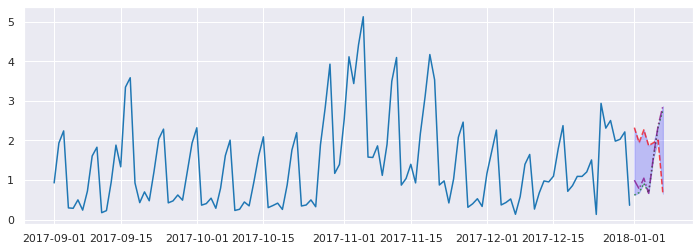

In [52]:
train_plot = train[['Day', 'BOLETOS']]
train_plot['Day'] = pd.to_datetime(train_plot['Day'])
plt.figure(figsize=(12, 4))
plt.plot(time_s['2017-09-01':], label="actual")
plt.plot(forecast_results['ARIMA'], c="r", linestyle='--', label="model-pred", alpha=0.7)
plt.plot(forecast_results['RndFR'], c="g", linestyle=':', label="model-pred", alpha=0.7)
plt.plot(forecast_results['LR'], c="purple", linestyle='-.', label="model-pred", alpha=0.7)
plt.fill_between(forecast_results.index, forecast_results['Min'], forecast_results['Max'], color='b', alpha=0.2)
plt.show()

## 6) Conclusion
This analysis uses a tickets sales combined with the movie data and holidays over a period of two years. Using feature engineerig, categories were created to bin the budget, time displayed in theaters, number of theathers where the movie was shown and the studio that produced the movie.
Analazing this dataset, the statistical tests show that there are features that skew the sample. Mainly some weekdays and weekends (Friday to Sunday). When constructing the linear models, a baseline was a Linear Regression Model according to the R^2 score and the residuals vs predictors. Then we tried a boosting technique and a classifier: Gradient Boosting and Random Forests. Random Forest regression probed to have a better score than linear regression. Also we treated the data as a time series and used an ARIMA model to test the forecasting. But this model goes againt the empirical and statistical findings about the importance of the end of the week (Friday to Sunday).
We can conclude that random forests works better to predict attendance performed better with this data set. Random Forest is a machine learning technique that does not require preselecting the covariates and it naturally avoids the hazard of overfitting. It also captures the importance of holidays and weekends in the attendance to theaters forecast.

We can conclude:
1) Cinema attendance is highly stationary. Weekends, holidays, summer and winter vacations is when we have higher rates of attendance.
2) Blockbusters from some studios tend to attract higher numbers of fans.
3) Using the Random Forest Classifier to forecast a week in advance can probe to be valuable for operations and their objetive to manage the inventory of selling concessions; avoid losses and get more profit.